In [59]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# fecbo-db完成形

## 0828~
マニュアル
m,c,a,bの値を設定する．  

fecbo-dbをirisdデータセットに適用し、遠藤教授が提案した評価方法によって分類結果を評価してみる  
よってfecbo-db(m=3,5,8)とfecbo-e(lambda=0.01,0.1)の5種類による結果をcsvファイルに保存することが目的

## 1.fecbo-db(m=3)

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
#sysはコマンドライン引数
import sys
import csv
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み
iris = pd.read_csv("../dataset/iris-dataset.csv")
df = iris.drop('species', axis=1)
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape

#クラスタ数宣言
c = 3
#Kはクラスタサイズ 
K = X_size /c
#交互最適化最大繰り返し数
max_iter = 100

#ファジィパラメーター設定
m = 3

#初期値繰り返し回数
NumberOfRepetitions= 50

In [61]:
#uの最適化部分関数作成
def u_optimize(d,c,m):
    #変数定義
    u_list = [0] * len(d)
    for i in range(len(d)):
        u_list[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u_list[i],m)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    Positive_Number = []
    Total_1 = []
    Total_K = []
    constraints = []
    #0以上
    for i in range (len(d)):
        Positive_Number.append(u_list[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        sum_iti = 0
        for j in range(c):    
            sum_iti += u_list[i+j]
        Total_1.append(sum_iti==1)
    
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    for i in range(c-1):
        Total_K.append(sum(u_list[i:len(d):c])==K)
        
    constraints.extend(Positive_Number)
    constraints.extend(Total_1)
    constraints.extend(Total_K)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u_list[i].value)
    u_array = u_value.reshape([X_size,c])
    #u_arrayに帰属度配列、resultに目的関数
    return u_array,result

In [62]:
#クラスタ中心計算部分関数作成
def v_calculation(u_m,c,dimension,X):
    #分母計算(クラスタサイズになるはず)
    v_denominator = np.sum(u_m,axis=0)
    
    #分子計算
    v_numerator = np.zeros((c,dimension))
    for j in range(c):
        for i in range(X_size):
            v_numerator[j]+= u_m[i][j]*X[i]
   
    v = np.zeros((c,dimension ))
    for i in range(c):
        v[i] = v_numerator[i]/v_denominator[i]
    return v

In [63]:
for s in range (NumberOfRepetitions):
    print(f"{s+1}回目")
    centroids = X[np.random.choice(X_size,c)]
    # kappa,epsilon = CreateEpsilon(a,b,X_size,dimension)       

    for epoch in range(max_iter):
        #print(f"{epoch+1}回目")
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]-centroids[j])**2))
        #uの更新
        u,J = u_optimize(d,c,m)
        u_m = u**m
        #vの更新
        new_centroids = v_calculation(u_m,c,dimension,X)

        # もしも重心が変わっていなかったら終了
        if np.sum(np.abs(new_centroids-centroids))<=0.000001:
            #print(new_centroids-centroids)
            print("中心が変わらないのでbreakします！")
            break
        centroids = np.copy(new_centroids)

    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if s == 0:
        np_cluster = np.argmax(u,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
        best_u = np.copy(u)
    elif best_J > J:
        np_cluster = np.argmax(u,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
        best_u = np.copy(u)
    print(f"{s+1}回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(np_cluster)
print(best_J)
print(best_centroids)

1回目
中心が変わらないのでbreakします！
1回目のクラスタリング結果↓
29.289735663519664
[[5.8798246  2.78053343 4.33476788 1.37513024]
 [6.65877698 3.02715931 5.5053254  2.01772972]
 [4.99946148 3.39023264 1.49106562 0.25094682]]
終了
2回目
中心が変わらないのでbreakします！
2回目のクラスタリング結果↓
29.289735663517206
[[5.87982398 2.78053322 4.33476709 1.37512988]
 [4.9994615  3.39023266 1.4910656  0.25094681]
 [6.65877679 3.02715925 5.50532521 2.01772955]]
終了
3回目
中心が変わらないのでbreakします！
3回目のクラスタリング結果↓
29.289735663517206
[[5.87982398 2.78053322 4.33476709 1.37512988]
 [4.9994615  3.39023266 1.4910656  0.25094681]
 [6.65877679 3.02715925 5.50532521 2.01772955]]
終了
4回目
中心が変わらないのでbreakします！
4回目のクラスタリング結果↓
29.289735663515227
[[4.99946149 3.39023266 1.4910656  0.25094681]
 [5.87982401 2.78053323 4.33476714 1.3751299 ]
 [6.6587768  3.02715926 5.50532522 2.01772956]]
終了
5回目
中心が変わらないのでbreakします！
5回目のクラスタリング結果↓
29.289735663504903
[[4.99946148 3.39023264 1.49106562 0.25094682]
 [5.87982459 2.78053342 4.33476786 1.37513023]
 [6.65877697 3.02715931 5.50532539 2

/Users/kouki/opt/anaconda3/envs/clustering/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


中心が変わらないのでbreakします！
15回目のクラスタリング結果↓
29.289735663504903
[[4.99946148 3.39023264 1.49106562 0.25094682]
 [5.87982459 2.78053342 4.33476786 1.37513023]
 [6.65877697 3.02715931 5.50532539 2.01772972]]
終了
16回目
中心が変わらないのでbreakします！
16回目のクラスタリング結果↓
29.289735663504903
[[4.99946148 3.39023264 1.49106562 0.25094682]
 [5.87982459 2.78053342 4.33476786 1.37513023]
 [6.65877697 3.02715931 5.50532539 2.01772972]]
終了
17回目
中心が変わらないのでbreakします！
17回目のクラスタリング結果↓
29.289735663504903
[[4.99946148 3.39023264 1.49106562 0.25094682]
 [5.87982459 2.78053342 4.33476786 1.37513023]
 [6.65877697 3.02715931 5.50532539 2.01772972]]
終了
18回目
中心が変わらないのでbreakします！
18回目のクラスタリング結果↓
29.289735663504903
[[4.99946148 3.39023264 1.49106562 0.25094682]
 [5.87982459 2.78053342 4.33476786 1.37513023]
 [6.65877697 3.02715931 5.50532539 2.01772972]]
終了
19回目
中心が変わらないのでbreakします！
19回目のクラスタリング結果↓
29.289735663504903
[[4.99946148 3.39023264 1.49106562 0.25094682]
 [5.87982459 2.78053342 4.33476786 1.37513023]
 [6.65877697 3.02715931 5.50532

[50. 50. 50.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


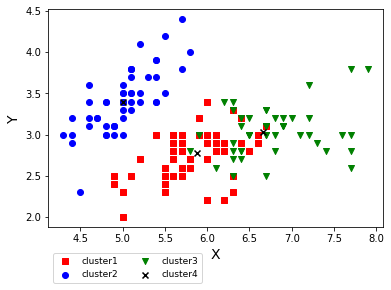

In [64]:
print(np.sum(u, axis=0))#列ごとの総和
print(np.sum(u, axis=1))#行ごとの総和
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
# colors = ['red', 'blue', 'green']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i],alpha=1.0)
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x",alpha = 1.0)
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
#ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9)  # 凡例を表示
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

#fig.savefig("iris_m3.pdf",bbox_inches='tight')

In [80]:
#csvファイル書き出しセル
#pandasで分割結果を記入
df["cluster"]=np_cluster
for i in range(c):
    df["u{}".format(i)] = best_u[:,i]
df.to_csv('fecbo-db-m3-iris.csv',index=False)
#目的関数を記入
with open ('fecbo-db-m3-iris.csv','a') as f:
    writer = csv.writer(f)
    writer.writerow(["J",best_J])
# print(df.drop(index='J'))

In [81]:
test = pd.read_csv("fecbo-db-m3-iris.csv")
test

,Unnamed: 0,sepal_length,sepal_width,petal_length,petal_width,cluster,u0,u1,u2
0,0,5.100000,3.5,1.4,0.2,1.0,0.060611,0.885228,0.054161
1,1,4.900000,3.0,1.4,0.2,1.0,0.108113,0.810330,0.081557
2,2,4.700000,3.2,1.3,0.2,1.0,0.101756,0.820053,0.078190
3,3,4.600000,3.1,1.5,0.2,1.0,0.122551,0.786852,0.090597
4,4,5.000000,3.6,1.4,0.2,1.0,0.070286,0.870102,0.059612
...,...,...,...,...,...,...,...,...,...
146,146,6.300000,2.5,5.0,1.9,2.0,0.396489,0.088777,0.514734
147,147,6.500000,3.0,5.2,2.0,2.0,0.173925,0.041181,0.784894
148,148,6.200000,3.4,5.4,2.3,2.0,0.257683,0.084530,0.657787
149,149,5.900000,3.0,5.1,1.8,2.0,0.432544,0.091590,0.475866


##　正解とのクラスター番号を合わせる作業セル

In [69]:
#正解リスト作成
dff = pd.read_csv("../dataset/iris-dataset.csv")
size_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
seikai = iris["species"].map(size_mapping).values
seikai

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [70]:
np_cluster

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2])

上記の二つのリストを比較してnp_clusterの番号を変更していく

0と1交換

In [71]:
cluster_hensyuu = np_cluster
cluster_hensyuu_0 = np.where(cluster_hensyuu==1, 100, np_cluster)
cluster_hensyuu_1 = np.where(cluster_hensyuu_0==0, 1, cluster_hensyuu_0)
cluster_hensyuu_2 = np.where(cluster_hensyuu_1==100, 0, cluster_hensyuu_1)

In [72]:
cluster_hensyuu_2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2])

In [75]:
#------正解率の算出
dff = pd.read_csv("../dataset/iris-dataset.csv")
size_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
seikai = iris["species"].map(size_mapping).values

seikaisuu = np.count_nonzero(cluster_hensyuu_2==seikai)
seikairitu= (np.count_nonzero(cluster_hensyuu_2==seikai))/X_size*100
print("正解率")
print(seikairitu)
print("正解数")
print(seikaisuu)
print("クラスタサイズ確認")
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))

正解率
90.66666666666666
正解数
136
クラスタサイズ確認
54
50
46


# csvファイルのuの値から評価関数の再計算

In [5]:
!pwd

/Users/kouki/Library/Mobile Documents/com~apple~CloudDocs/Desktop/python/Clustering_research/TransPortation/iris_classification


In [13]:
import numpy as np
import pandas as pd
#_______________入力ファイルやパラメータ指定部分_______________
c = 3
m = 3
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み
df = pd.read_csv("./iris_csvFile/Iris-m3.csv")
df

,sepal_length,sepal_width,petal_length,petal_width,cluster,u0,u1,u2,J,F
0,5.1,3.5,1.4,0.2,1.0,0.060611,0.885228,0.054161,29.289736,835.958407
1,4.9,3.0,1.4,0.2,1.0,0.108113,0.810330,0.081557,29.289736,835.958407
2,4.7,3.2,1.3,0.2,1.0,0.101756,0.820053,0.078190,29.289736,835.958407
3,4.6,3.1,1.5,0.2,1.0,0.122551,0.786852,0.090597,29.289736,835.958407
4,5.0,3.6,1.4,0.2,1.0,0.070286,0.870102,0.059612,29.289736,835.958407
...,...,...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0,0.181321,0.054109,0.764570,29.289736,835.958407
146,6.3,2.5,5.0,1.9,2.0,0.396489,0.088777,0.514734,29.289736,835.958407
147,6.5,3.0,5.2,2.0,2.0,0.173925,0.041181,0.784894,29.289736,835.958407
148,6.2,3.4,5.4,2.3,2.0,0.257683,0.084530,0.657787,29.289736,835.958407


In [ ]:
df = df.iloc[:151]

J = df.iloc[-1][1]
df = df.iloc[:-1]

u_pd = []
for i in range(c):
    u_pd.append("u{}".format(i))
df_u = df.loc[:,u_pd]
u = df_u.values

df_X = df.loc[:,"sepal_length":"petal_width"]
# df_X = df.loc[:,"0":"1"]

#dfをnumpyで扱えるnp.ndarray変換
X = df_X.values
X = X.astype('float64')
#配列の行数、列数の格納
X_size,dimension = X.shape
cluster = df["cluster"].values

u_m = u**m
v = v_calculation(u_m,c,dimension,X)

#中心間距離の作成
center_distance = np.zeros((c,c))
for i in range(c):
    for j in range(c):
        center_distance[i][j]= np.sum((v[i]-v[j])**2)
print("center_distance")
print(center_distance)
#dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
d=[]
for i in range(X_size):
    for j in range(c):
        d.append(np.sum((X[i]-v[j])**2))
d = np.array(d)
d = d.reshape([X_size,c])
print("d_{ki}")
print(d[0])
for i in range(c):
    d[cluster == i] = d[cluster == i]+center_distance[i]
print("d_{ki}+d_{ii*}")
print(d[0]) 

#評価関数計算
F = 0
for i in range(X_size):
    for j in range(c):
        F += u[i][j] * d[i][j]
        
        
#この初期値のときの結果が優れている場合，bestを更新
print("Jの値:",J)
print("Fの値:",F)

In [6]:
from ipynb.fs.full.calculator import calculate_ep

KeyError: '__package__'

In [ ]:
#_____________epsilon更新セル____________________________
#____________epsilon初期値を作成__________________
#任意の範囲（[a, b): a以上、b未満）の乱数を取得したい場合
#(b - a) * np.random.rand() + a
a = 0.05
b = 0.08
kappa = (b - a) * np.random.rand(X_size,dimension) + a
#kappaを定義
epsilon = np.zeros((X_size,dimension))
for i in range(X_size):
    for j in range(dimension):
        ep_max = kappa[i][j]
        epsilon[i][j] = (ep_max + ep_max) * np.random.rand() - ep_max
#_____________epsilonの更新用に定義______________
new_epsilon = np.zeros((X_size,dimension))

u_array_m = u_array**3
u_sum = np.sum(u_array_m,axis=1)#u_mの行ごとの合計値,epの分母

#_____________not_alpha作成部分__________________
not_alpha = np.zeros((X_size,dimension)) #ipsilon = alpha * not_alpha,not_alphaは絶対値の部分の分母にも使えそう
for k in range(X_size):
    for j in range(dimension):
        sum_uxv = 0
        for i in range(c):
            sum_uxv +=u_array_m[k][i]*(X[k][j]-centroids[i][j])
        not_alpha[k][j]= sum_uxv
        
ep_denominator = np.abs((not_alpha)*-1)
alpha_kari = kappa/ep_denominator
alpha_kari1 = 1/u_sum
alpha_list = np.insert(alpha_kari, -1, alpha_kari1, axis=1)#alphaのminリスト作成完了
#______________epsilonの更新___________________
for i in range(X_size):
    for j in range(dimension):
        if alpha_list[i][j] < alpha_list[i][-1]:
            epsilon[i][j] = alpha_list[i][j]*not_alpha[i][j]*-1
        else:
            epsilon[i][j] = alpha_list[i][-1]*not_alpha[i][j]*-1